In [1]:
import yaml
import json

import pandas as pd
import numpy as np
import tensorflow as tf

from pathlib import Path
from pymatgen.core import Structure
from sklearn.model_selection import train_test_split
from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph
# tf.config.experimental.list_physical_devices('GPU')

In [2]:
def read_pymatgen_dict(file):
    with open(file, "r") as f:
        d = json.load(f)
    return Structure.from_dict(d)


def energy_within_threshold(prediction, target):
    # compute absolute error on energy per system.
    # then count the no. of systems where max energy error is < 0.02.
    e_thresh = 0.02
    error_energy = tf.math.abs(target - prediction)

    success = tf.math.count_nonzero(error_energy < e_thresh)
    total = tf.size(target)
    return success / tf.cast(total, tf.int64)

def prepare_dataset(dataset_path):
    dataset_path = Path(dataset_path)
    targets = pd.read_csv(dataset_path / "targets.csv", index_col=0)
    struct = {
        item.name.strip(".json"): read_pymatgen_dict(item)
        for item in (dataset_path / "structures").iterdir()
    }

    data = pd.DataFrame(columns=["structures"], index=struct.keys())
    data = data.assign(structures=struct.values(), targets=targets)

#     return train_test_split(data, test_size=0.25, random_state=43)
    return data

 
def prepare_model(cutoff, lr):
    nfeat_bond = 10
    r_cutoff = cutoff
    gaussian_centers = np.linspace(0, r_cutoff + 1, nfeat_bond)
    gaussian_width = 0.5
    
    return MEGNetModel(
        graph_converter=CrystalGraph(cutoff=r_cutoff),
        centers=gaussian_centers,
        width=gaussian_width,
        loss=["MAE"],
        npass=3,
        lr=lr,
        metrics=energy_within_threshold
    )


def main(config):
    train, test = prepare_dataset(config["datapath"])
    model = prepare_model(
        float(config["model"]["cutoff"]),
        float(config["model"]["lr"]), 
    )
    model.train(
        train.structures,
        train.targets,
        validation_structures=test.structures,
        validation_targets=test.targets,
        epochs=int(config["model"]["epochs"]),
        batch_size=int(config["model"]["batch_size"]),
    )

In [3]:
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [4]:
# main(config)

In [5]:
# def sub(config):
#     model = prepare_model(
#         float(config["model"]["cutoff"]), float(config["model"]["lr"])
#     )
#     model.load_weights(config['checkpoint_path'])

#     dataset_path = Path(config['test_datapath'])
#     struct = {item.name.strip('.json'): read_pymatgen_dict(item) for item in (dataset_path/'structures').iterdir()}
#     private_test = pd.DataFrame(columns=['id', 'structures'], index=struct.keys())
#     private_test = private_test.assign(structures=struct.values())
#     private_test = private_test.assign(predictions=model.predict_structures(private_test.structures))
#     private_test[['predictions']].to_csv('./submission.csv', index_label='id')
# with open("/content/drive/MyDrive/Project/International-Data-Analysis-Olympiad-2022/Student Division/config.yaml") as file:
#     config = yaml.safe_load(file)
# sub(config)

In [6]:
data = prepare_dataset(config["datapath"])
train, test = train_test_split(data, test_size=0.25, random_state=43)

/home/quyanh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='targets'>

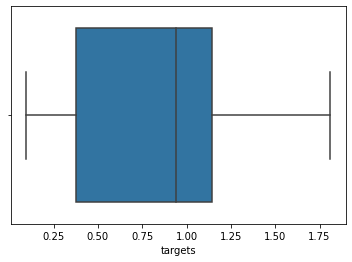

In [15]:
# from scipy import stats
# z_scores = stats.zscore(data.targets)
# z_scores

# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3).all()
# filtered_entries
# new_data = data[filtered_entries]

# print(new_data)
import seaborn as sns 
sns.boxplot(data.targets)

In [18]:
data

,structures,targets
6141dab9ee0a3fd43fb47c25,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3363
6141eb033ac25c70a5c6c9d1,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3565
6141f32731cf3ef3d4a9f166,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3543
6141f4da4e27a1844a5f0476,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1384
6141f84631cf3ef3d4a9f1a4,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3571
...,...,...
614236834e27a1844a5f06c6,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1471
6141d54b31cf3ef3d4a9ef0e,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4219
6142567031cf3ef3d4a9f486,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3920
6141d03c4e27a1844a5f00ba,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1452


In [10]:
print(train.shape)
print(type(train))

(2224, 2)
<class 'pandas.core.frame.DataFrame'>


In [24]:
data.drop_duplicates(subset='targets')

,structures,targets
6141dab9ee0a3fd43fb47c25,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3363
6141eb033ac25c70a5c6c9d1,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3565
6141f32731cf3ef3d4a9f166,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3543
6141f4da4e27a1844a5f0476,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1384
6141f84631cf3ef3d4a9f1a4,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3571
...,...,...
6141cfd43ac25c70a5c6c877,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4260
6141f41a4e27a1844a5f046a,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.1407
6141ece2ee0a3fd43fb47d57,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3360
61422efc31cf3ef3d4a9f39c,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3830


In [26]:
data.structures[1]

Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999994 22.10315553833868 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
PeriodicSite: Mo (0.0000, 1.8419, 3.7198) [0.0417, 0.0833, 0.2500]
PeriodicSite: Mo (-1.5952, 4.6048, 3.7198) [0.0417, 0.2083, 0.2500]
PeriodicSite: Mo (-3.1903, 7.3677, 3.7198) [0.0417, 0.3333, 0.2500]
PeriodicSite: Mo (-4.7855, 10.1306, 3.7198) [0.0417, 0.4583, 0.2500]
PeriodicSite: Mo (-6.3806, 12.8935, 3.7198) [0.0417, 0.5833, 0.2500]
PeriodicSite: Mo (-7.9758, 15.6564, 3.7198) [0.0417, 0.7083, 0.2500]
PeriodicSite: Mo (-9.5709, 18.4193, 3.7198) [0.0417, 0.8333, 0.2500]
PeriodicSite: Mo (-11.1661, 21.1822, 3.7198) [0.0417, 0.9583, 0.2500]
PeriodicSite: Mo (3.1903, 1.8419, 3.7198) [0.1667, 0.0833, 0.2500]
PeriodicSite: Mo (1.5952, 4.6048, 3.7198) [0.1667, 0.2083, 0.2500]
PeriodicSite: Mo (0.0000, 7.3677, 3

In [29]:
data.structures[2] # == data.structures[1]

Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999994 22.10315553833868 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
PeriodicSite: Mo (0.0000, 1.8419, 3.7198) [0.0417, 0.0833, 0.2500]
PeriodicSite: Mo (-1.5952, 4.6048, 3.7198) [0.0417, 0.2083, 0.2500]
PeriodicSite: Mo (-3.1903, 7.3677, 3.7198) [0.0417, 0.3333, 0.2500]
PeriodicSite: Mo (-4.7855, 10.1306, 3.7198) [0.0417, 0.4583, 0.2500]
PeriodicSite: Mo (-6.3806, 12.8935, 3.7198) [0.0417, 0.5833, 0.2500]
PeriodicSite: Mo (-7.9758, 15.6564, 3.7198) [0.0417, 0.7083, 0.2500]
PeriodicSite: Mo (-9.5709, 18.4193, 3.7198) [0.0417, 0.8333, 0.2500]
PeriodicSite: Mo (-11.1661, 21.1822, 3.7198) [0.0417, 0.9583, 0.2500]
PeriodicSite: Mo (3.1903, 1.8419, 3.7198) [0.1667, 0.0833, 0.2500]
PeriodicSite: Mo (1.5952, 4.6048, 3.7198) [0.1667, 0.2083, 0.2500]
PeriodicSite: Mo (0.0000, 7.3677, 3

In [11]:
train.index

Index(['6141db179cbada84a8676a21', '614259f2ee0a3fd43fb47f3f',
       '6141d342ee0a3fd43fb47b3f', '6141d14eee0a3fd43fb47adb',
       '6141d2b24e27a1844a5f0158', '6141d01e31cf3ef3d4a9edf0',
       '6142c0344e27a1844a5f0912', '614248bd31cf3ef3d4a9f430',
       '6141cfd7baaf234b35290210', '6141f597ee0a3fd43fb47db7',
       ...
       '6141f82c4e27a1844a5f04a4', '614391c43ac25c70a5c6cd15',
       '61420d8e31cf3ef3d4a9f292', '614202eb31cf3ef3d4a9f21a',
       '61420f4f4e27a1844a5f05a0', '6141e7613ac25c70a5c6c9b9',
       '614217a731cf3ef3d4a9f2e6', '6141d889baaf234b3529037a',
       '614294843ac25c70a5c6cc09', '6143bd0f31cf3ef3d4a9f794'],
      dtype='object', length=2224)

In [13]:
my = [] + [5] + 
my

[5]